In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import math
# read the file into a list of lines and print to separate files for different outputs
link_to_files = "results/"
for d in [4,5,6]:
    for version in ["basic", "ensemble", "modelstore"]:
        with open(link_to_files+"results_"+version+"_"+str(d)+".txt",'r') as f:
            lines = f.read().split("\n")
        output_file_perf = open(link_to_files+version+"/Performance_Output_"+ str(d)+".txt", "w")
        output_file_retrainings = open(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt", "w")
        output_file_update = open(link_to_files+version+"/Update_Output_"+ str(d)+".txt", "w")
        word_perf = 'Test batch'
        word_drift = 'Change detected'
        word_nondrift = 'No drift but'
        word_update = 'Online model is updated'
        # iterate over lines, and print out line numbers which contain the word of interest.
        for j,line in enumerate(lines):
            if word_perf in line: # or word in line.split() to search for full word
                print("{}".format(line), file=output_file_perf)
            if word_drift in line:
                print("{}".format(line), file=output_file_retrainings)
            if word_update in line:
                print("{}".format(line), file=output_file_update)
            if word_nondrift in line:
                print("{}".format(line), file=output_file_retrainings)
        output_file_perf.close()
        output_file_retrainings.close()
        output_file_update.close()
#Read data from the output files
# Get test scores and batch numbers
results={}
retrainings={}
for d in [4, 5, 6]:  # data streams
    results["AutOL_Data_" + str(d)]={}
    retrainings["AutOL_Data_" + str(d)] = {}
    for version in ["basic", "ensemble", "modelstore"]:
        #Get performance
        read_perf = pd.read_table(link_to_files+version+"/Performance_Output_"+ str(d)+".txt", header=None, sep=' ')
        results["AutOL_Data_" + str(d)][version] = (read_perf.iloc[:, [3, 6]])
        results["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Test score']
        results["AutOL_Data_" + str(d)][version]['Test score'] = results["AutOL_Data_" + str(d)][version]['Test score'].str.rstrip('%').astype('float') / 100.0
        #Get retraining points and types - No : no drift training point, Change: drift training point
        if os.path.getsize(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt") > 0:
            read_retraining = pd.read_table(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt", header=None, sep=' ')
            retrainings["AutOL_Data_" + str(d)][version] = read_retraining.iloc[:, [5,0]]
            retrainings["AutOL_Data_" + str(d)][version].columns = ['Batch number', 'Type']
        #Get model switch to ensemble/model store or AutOL output
        if version != "basic" and os.path.getsize(link_to_files+version+"/Retrainings_Output_"+ str(d)+".txt") > 0:
            read_update = pd.read_table(link_to_files+version+"/Update_Output_"+ str(d)+".txt", header=None, sep=' ', names=list(range(8)))
            retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]
            if version == "modelstore":
                retrainings["AutOL_Data_" + str(d)][version]['Model update'] = retrainings["AutOL_Data_" + str(d)][version]['Model update'].shift(5)
                retrainings["AutOL_Data_" + str(d)][version]['Model update'].replace(np.nan, "AutoML", inplace=True)
                retrainings["AutOL_Data_" + str(d)][version].reset_index(drop=True, inplace=True)
retrainings

<ipython-input-8-efbf61130cf5>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["AutOL_Data_" + str(d)][version]['Test score'] = results["AutOL_Data_" + str(d)][version]['Test score'].str.rstrip('%').astype('float') / 100.0
<ipython-input-8-efbf61130cf5>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retrainings["AutOL_Data_" + str(d)][version]['Model update'] = read_update.iloc[:, [6]]
<ipython-input-8-efbf61130cf5>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

{'AutOL_Data_4': {'basic':     Batch number    Type
  0          55001      No
  1         105002      No
  2         155003      No
  3         158412  Change
  4         159565  Change
  5         160610  Change
  6         162057  Change
  7         163137  Change
  8         164186  Change
  9         165349  Change
  10        166446  Change
  11        167570  Change
  12        168945  Change
  13        218946      No
  14        268947      No
  15        318948      No
  16        368949      No
  17        418950      No
  18        468951      No,
  'ensemble':     Batch number    Type Model update
  0           6172  Change    Ensemble.
  1           9656  Change    Ensemble.
  2          10819  Change       AutoML
  3          12053  Change    Ensemble.
  4          13422  Change    Ensemble.
  5          14742  Change    Ensemble.
  6          64743      No    Ensemble.
  7         114744      No    Ensemble.
  8         164745      No    Ensemble.
  9         214746    

In [9]:
def make_marker_array(a,e,choice):
    b= a[choice]
    c = list(b['Batch number'])
    r = []
    for j in c:
        i = math.ceil(j/1000)*1000
        r.append(i)
    both = set(r).intersection(e)
    e=list(e)
    markon = [e.index(x) for x in both]
    return markon

[154, 159, 463, 100, 313, 153, 158, 163, 413, 157, 50, 162, 263, 161, 150, 155, 363, 160, 213]
[2, 153, 453, 3, 103, 203, 303, 53, 353, 403, 253, 1]
[50, 150, 242, 445, 239, 243, 295, 395, 100, 236, 192, 240, 345, 237, 245, 241]


<ipython-input-42-34b858e5b538>:100: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[d].show()
<ipython-input-42-34b858e5b538>:100: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[d].show()
<ipython-input-42-34b858e5b538>:100: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figs[d].show()


<Figure size 1800x1440 with 0 Axes>

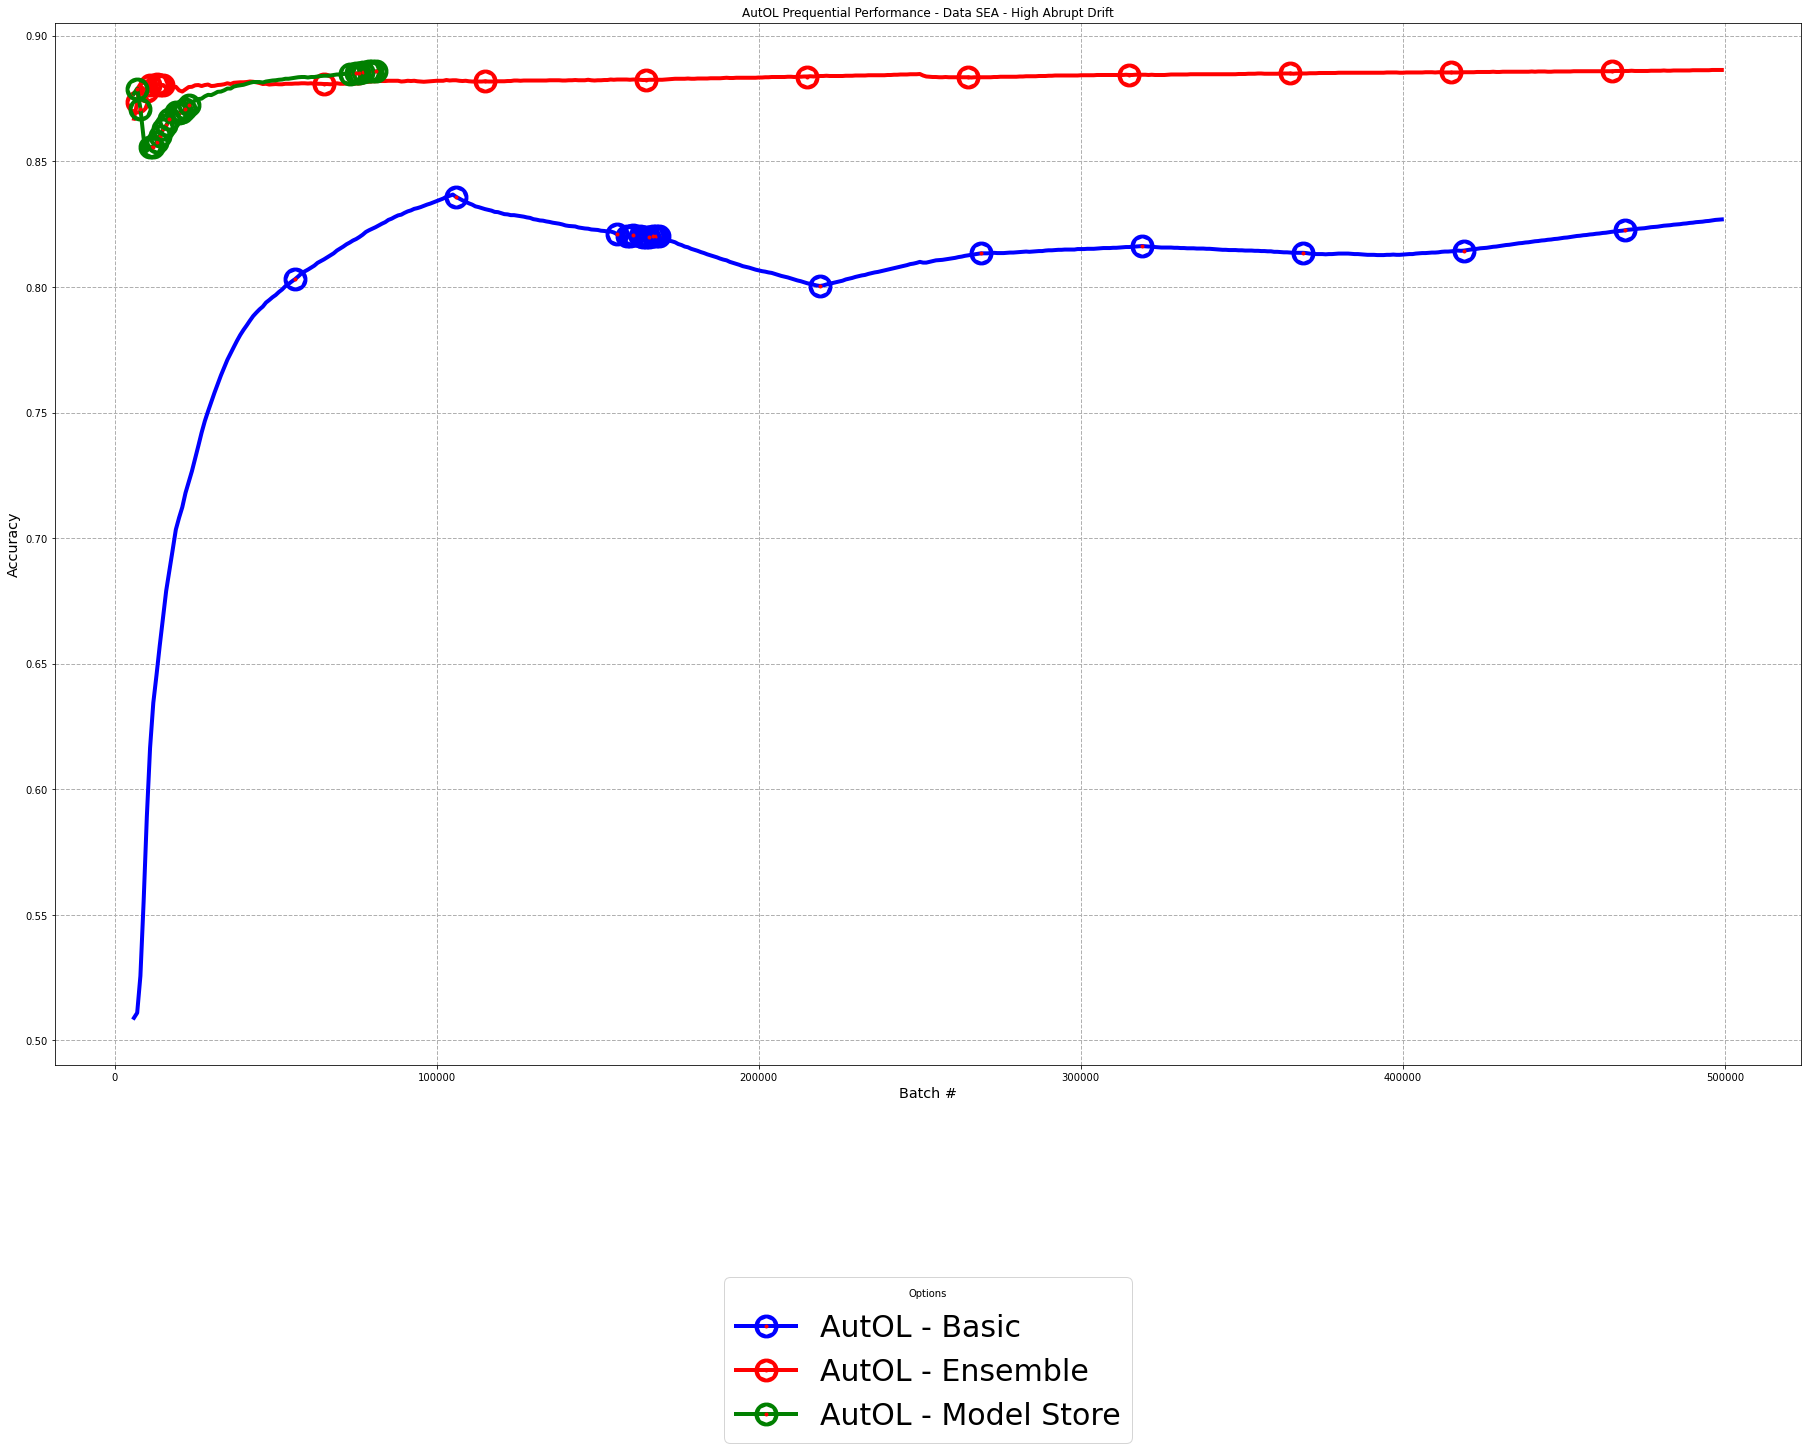

<Figure size 1800x1440 with 0 Axes>

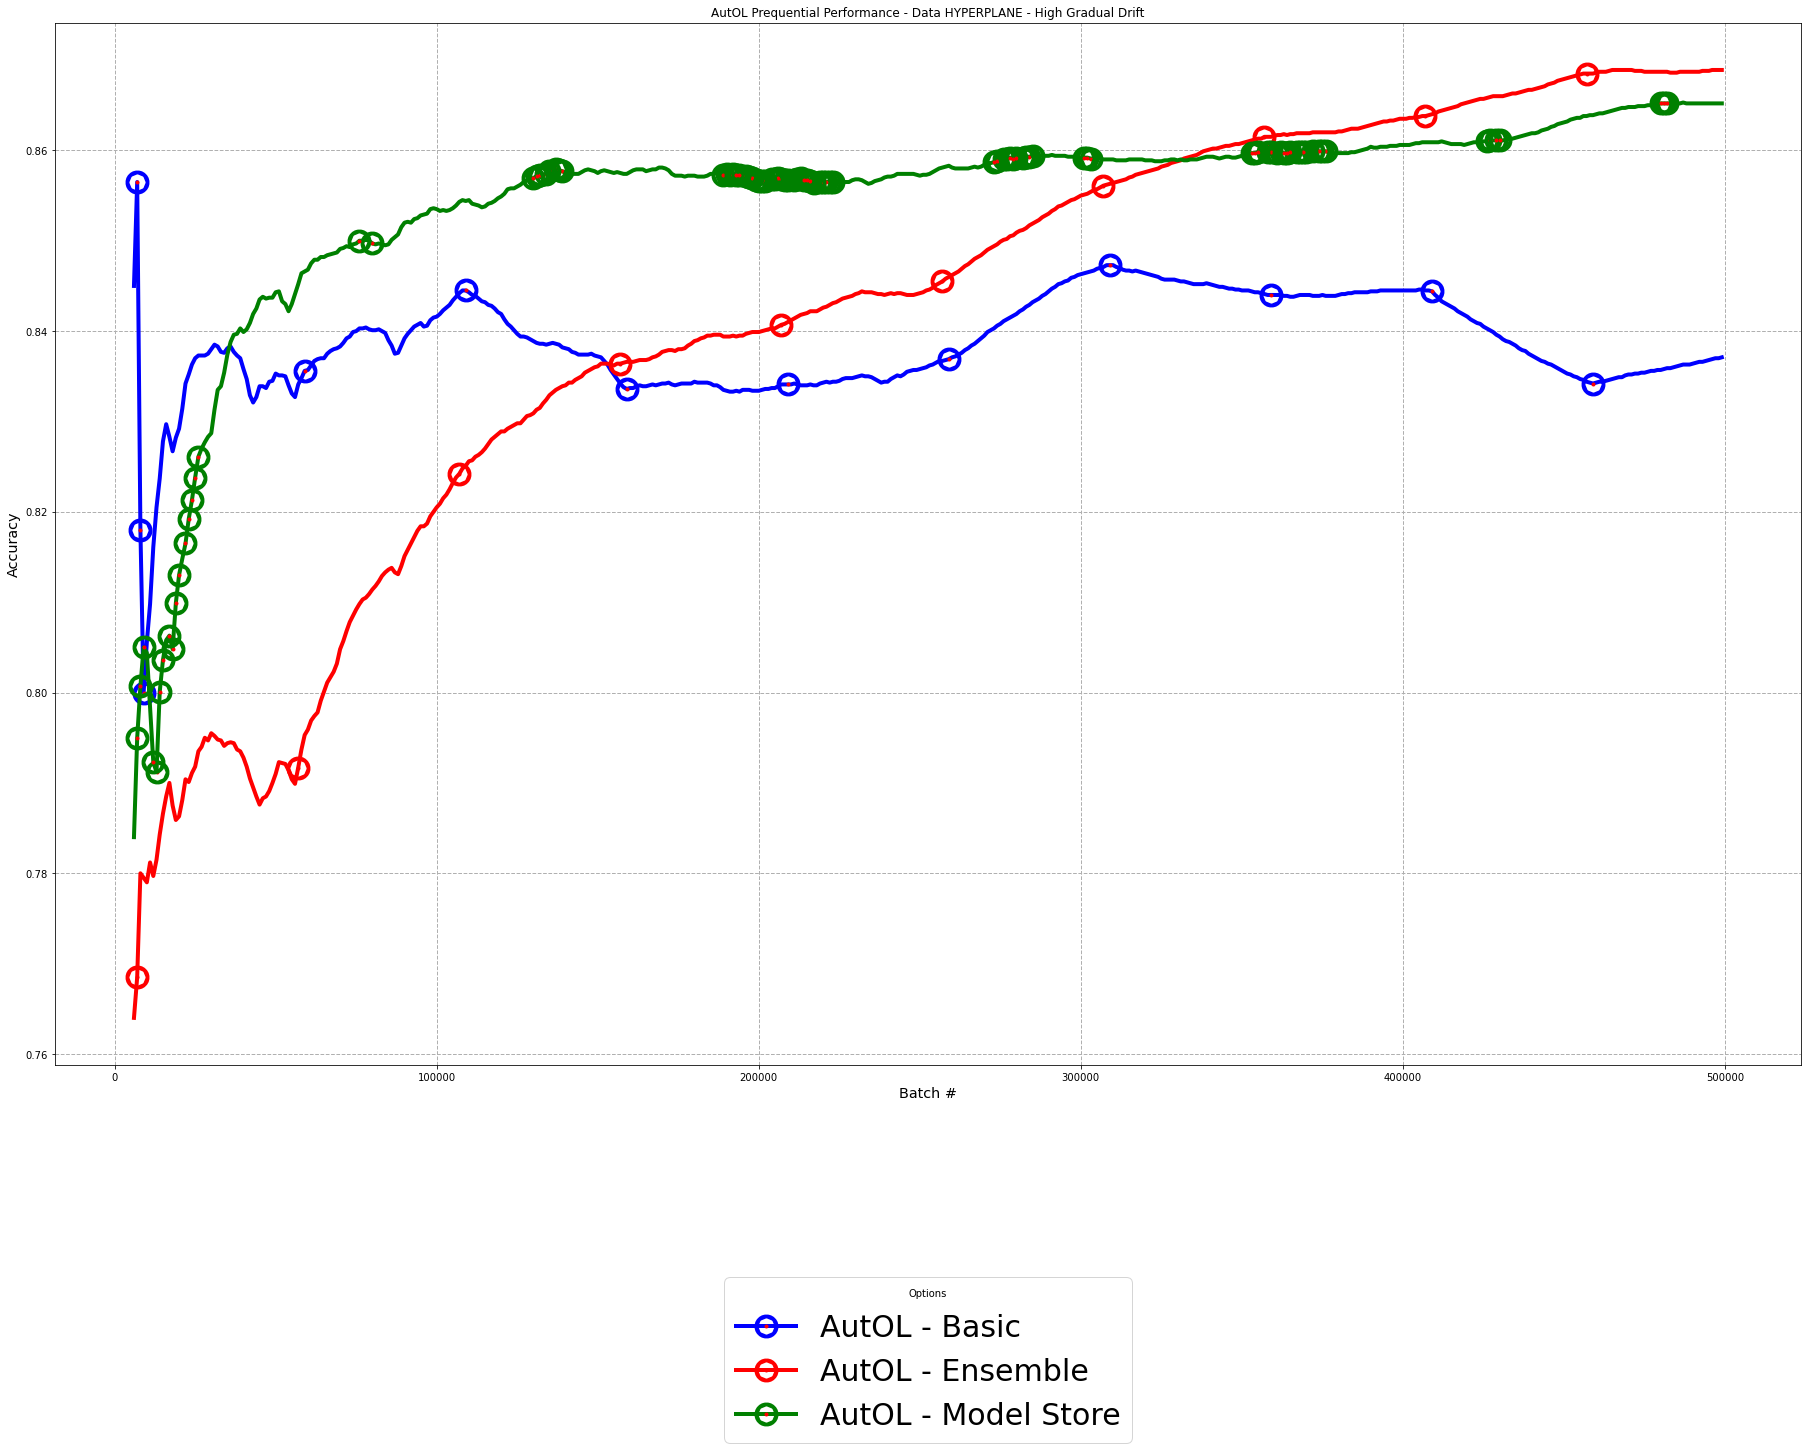

<Figure size 1800x1440 with 0 Axes>

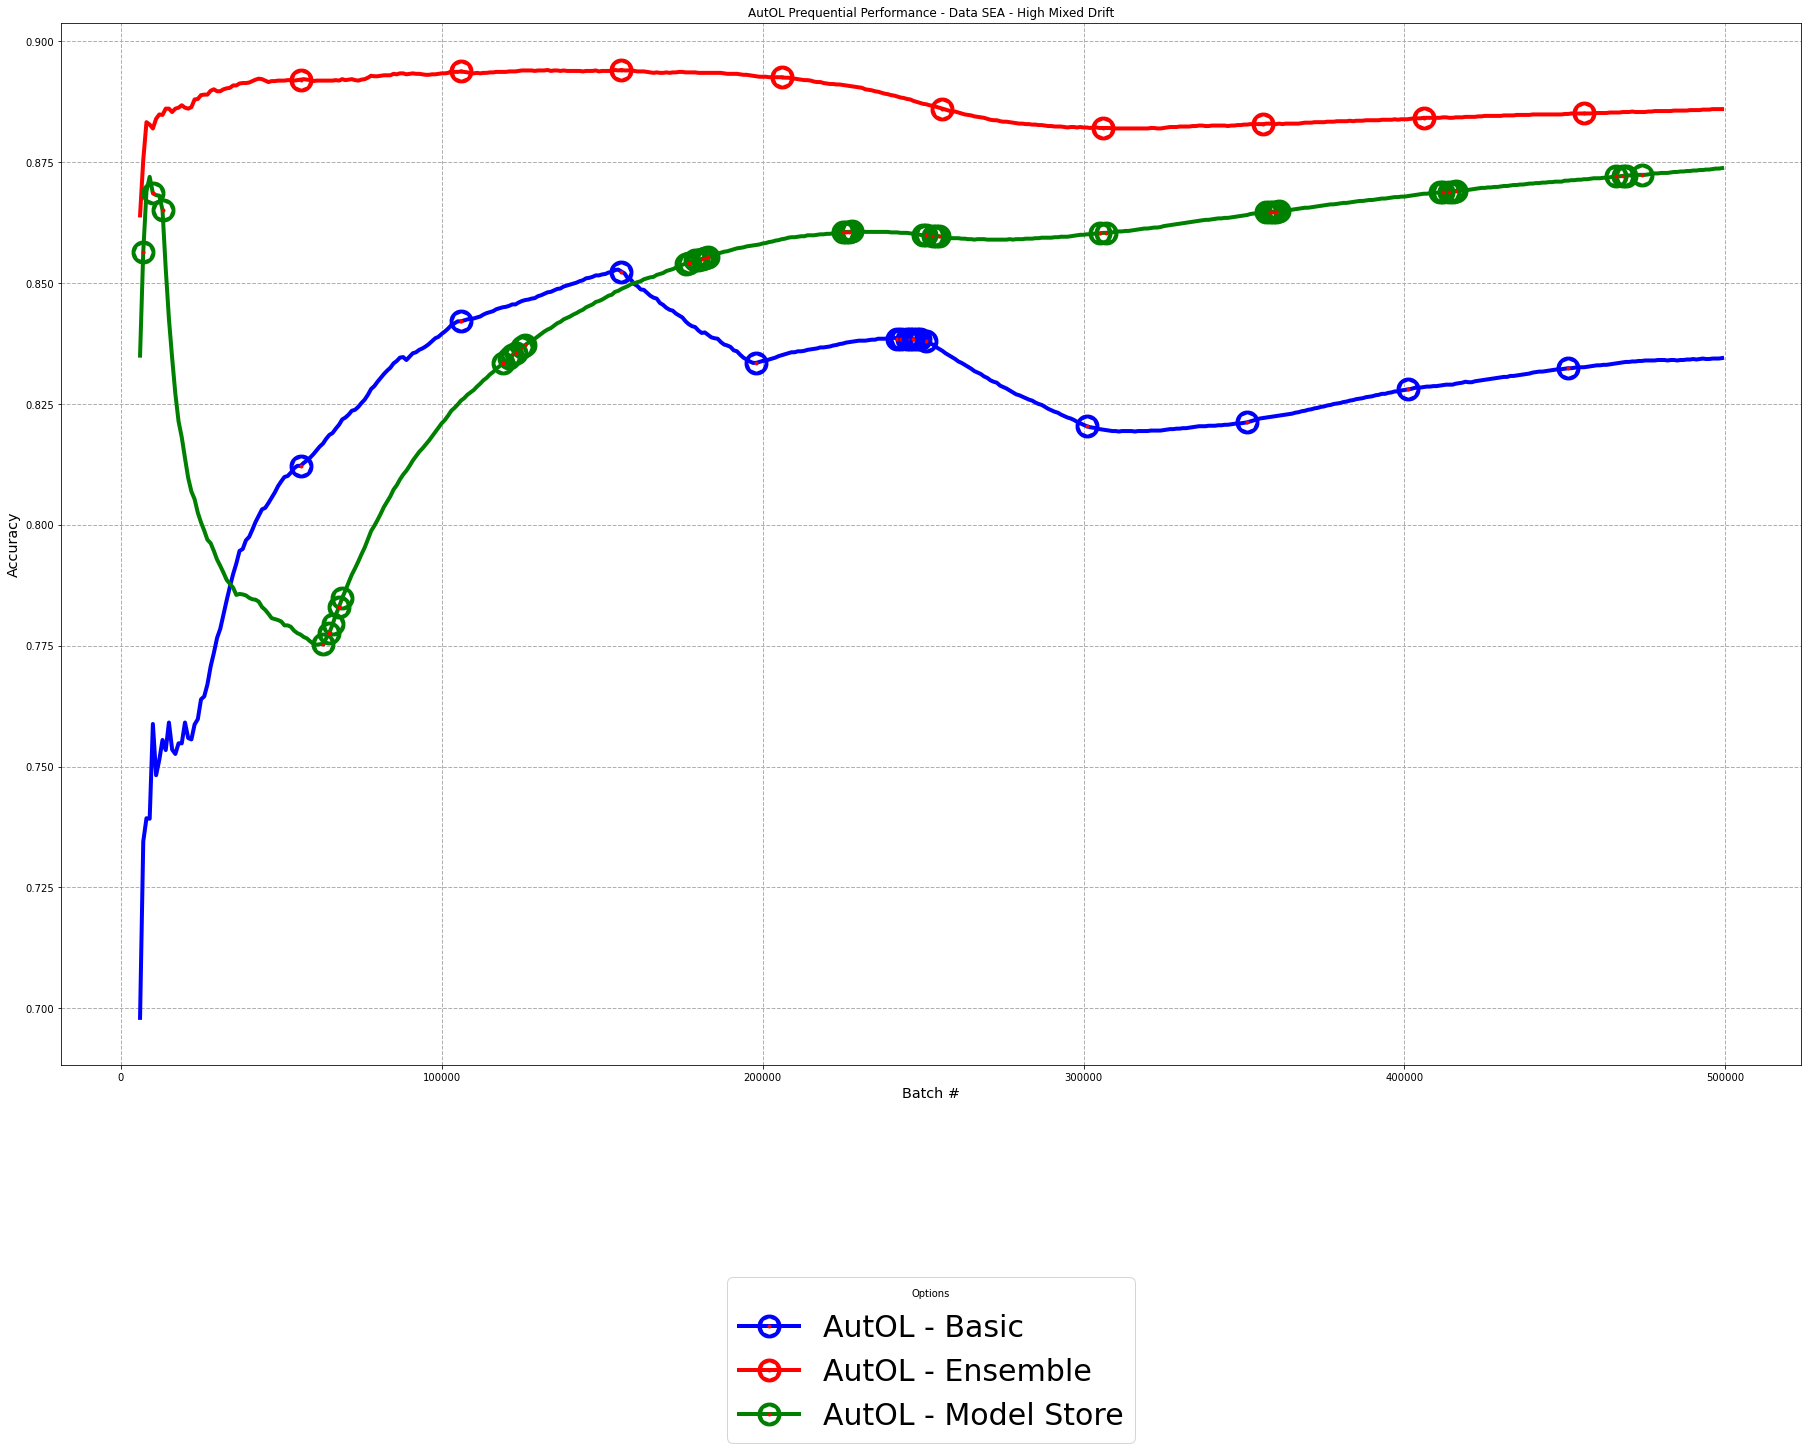

In [42]:
import matplotlib

#Plot-1 Performance
import math
figs = {}

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 35

data_names = ["Electricity", "Airlines",  "IMDB", "Vehicle", "SEA - High Abrupt Drift", "HYPERPLANE - High Gradual Drift",
              "SEA - High Mixed Drift"]


#     figs[d].savefig("/Users/prabhant/OpenML/gama/Results_AutOL/Performance_Data"+str(d)+".png")



    #For lines of drift and retraining in second plot

    # if os.path.getsize("/Users/prabhant/OpenML/gama/Results_AutOL/Grace/Retrainings_Output_"+ str(d)+".txt") > 0:
    #     i=0
    #     for xc in retrainings["AutOL_Ensemble_Data_" + str(d)]['Batch number']:
    #         if retrainings["AutOL_Ensemble_Data_" + str(d)]['Type'].iloc[i] == "Change":
    #             ax.axvline(x=xc, linestyle=':', color='b')
    #         else:
    #             ax.axvline(x=xc, linestyle='solid', color='b')
    #         i=i+1
    #
    # if os.path.getsize("/Users/prabhant/OpenML/gama/Results_AutOL/Grace/Retrainings_Output_"+ str(d+1)+".txt") > 0:
    #     i=0
    #     for xc in retrainings["AutOL_Ensemble_Data_" + str(d+1)]['Batch number']:
    #         if retrainings["AutOL_Ensemble_Data_" + str(d+1)]['Type'].iloc[i] == "Change":
    #             ax.axvline(x=xc, linestyle=':', color='r')
    #         else:
    #             ax.axvline(x=xc, linestyle='solid', color='r')
    #         i=i+1

def make_marker_array(a,e,choice):
    b= a[choice]
    c = list(b['Batch number'])
    r = []
    for j in c:
        i = math.ceil(j/1000)*1000
        r.append(i)
    both = set(r).intersection(e)
    e=list(e)
    markon = [e.index(x) for x in both]
    return markon
for d in [4, 5, 6]:
    ### Marker basic
    a = retrainings['AutOL_Data_'+str(d)]
    e = results["AutOL_Data_" + str(d)]['basic']['Batch number']
    markonb = make_marker_array(a,e,'basic')
    print(markonb)
    e = results["AutOL_Data_" + str(d)]['ensemble']['Batch number']
    markone = make_marker_array(a,e,'ensemble')
    e = results["AutOL_Data_" + str(d)]['modelstore']['Batch number']
    markonm = make_marker_array(a,e,'modelstore')
    ##############################################################
    plt.rcParams["figure.figsize"] = (25, 20)
    plt.rcParams["axes.labelsize"] = ('x-large')
    figs[d] = plt.figure()
    figs[d], ax = plt.subplots(1, 1, sharex='col', sharey='row', constrained_layout=True)

    ax.set(xlabel="Batch #", ylabel="Accuracy")
    ax.grid(linestyle='--', linewidth=1)

    ax.set_title('AutOL Prequential Performance - Data '+data_names[int(d)])

    #Plot performance lines of each version
    # basic
    l0 = ax.plot(results["AutOL_Data_" + str(d)]['basic']['Batch number'],
                    results["AutOL_Data_" + str(d)]['basic']['Test score'],
                    'o',markeredgewidth=20 ,markerfacecolor='red',ls='-', ms=4, markevery=markonb,
                    label='AutOL - Basic', lw=4, color='b')
    #ensemble
    l1 = ax.plot(results["AutOL_Data_" + str(d)]['ensemble']['Batch number'],
                    results["AutOL_Data_" + str(d)]['ensemble']['Test score'],
                    'o',markeredgewidth=20 ,markerfacecolor='red',ls='-', ms=4, markevery=markone,
                    label='AutOL - Ensemble', lw=4, color='r')
    #model store
    l2 = ax.plot(results["AutOL_Data_" + str(d)]['modelstore']['Batch number'],
                    results["AutOL_Data_" + str(d)]['modelstore']['Test score'],
                    'o',markeredgewidth=20 ,markerfacecolor='red',ls='-', ms=4, markevery=markonm,
                    label='AutOL - Model Store', lw=4, color='g')


    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels,
               loc='upper center',
               bbox_to_anchor=(0.5, -0.2),
               ncol=1,
               borderaxespad=0.1,
               title="Options",
               prop={'size': 30})
    #plt.yticks(np.arange(results["AutOL_Ensemble_Data_" + str(d)]['Test score'], results["AutOL_Ensemble_Data_" + str(d)]['Test score']+0.1, 0.1))

    plt.plot()
    figs[d].show()

In [28]:
a = retrainings['AutOL_Data_'+str(6)]
e = results["AutOL_Data_" + str(d)]['modelstore']['Batch number']
b= a['modelstore']
c = list(b['Batch number'])
r = []
for j in c:
    i = math.ceil(j/1000)*1000
    r.append(i)
both = set(r).intersection(e)
e=list(e)
[e.index(x) for x in both]


[170,
 410,
 405,
 63,
 175,
 351,
 463,
 4,
 116,
 244,
 468,
 57,
 249,
 409,
 62,
 174,
 222,
 462,
 115,
 355,
 120,
 248,
 408,
 173,
 221,
 301,
 354,
 7,
 119,
 247,
 60,
 220,
 460,
 1,
 113,
 177,
 353,
 406,
 59,
 171,
 219,
 299,
 176,
 352,
 117,
 245]

In [39]:
results["AutOL_Data_" + str(4)]['modelstore']['Batch number'],

(0      6000
 1      7000
 2      8000
 3      9000
 4     10000
       ...  
 72    78000
 73    79000
 74    80000
 75    81000
 76    82000
 Name: Batch number, Length: 77, dtype: int64,)

In [38]:
               results["AutOL_Data_" + str(d)]['basic']['Test score'],

0     0.8770
1     0.8790
2     0.8710
3     0.8592
4     0.8542
       ...  
72    0.8858
73    0.8858
74    0.8858
75    0.8858
76    0.8860
Name: Test score, Length: 77, dtype: float64

In [22]:

#      return int(math.ceil(x / 100.0)) * 100

In [81]:
e = results["AutOL_Data_" + str(d)]['basic']['Batch number']
both = set(c).intersection(e)

NameError: name 'c' is not defined

In [96]:
markon = [e.index(x) for x in both]


In [94]:
e=list(e)